In [1]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot

import os
import scipy
import awkward as ak
import time
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import *

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [2]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

# for data_year in ['2022','2023','all']:
for data_year in ['all']:
    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v13/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v13/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"
path_sig = "/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized/"
mass = [15,23,30,40,55]
ctau = [1,10,100,1000,10000,100000]
decay = ['B']
for d in decay:
    for m in mass:
        for ct in ctau:
            fpath[f'{m}_{ct}'] = f'{path_sig}/ggH_Hto2Sto4{d}_MH-125-MS-{m}-ctauS-{ct}_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v13/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
15_1 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized//ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57327670.0
15_10 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized//ggH_Hto2Sto4B_MH-125-MS-15-ctauS-10_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 56095530.0
15_100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized//ggH_Hto2Sto4B_MH-125-MS-15-ctauS-100_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57049570.0
15_1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized//ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_5

# apply selections

In [34]:
%%time


JET_PT_CUT = 30
MUON_PT_CUT = 30.0
N_RECHIT_CUT = 90

cscRechitClusterPhi0 = {}
cscRechitClusterPhi1 = {}
deltaPhi_cluster  = {}
cscRechitClusterDNN0  = {}
cscRechitClusterDNN1  = {}
cscRechitClusterTime0  = {}
cscRechitClusterTime1  = {}
cscRechitClusterSize0  = {}
cscRechitClusterSize1  = {}
weight = {}
sel_ev = {}
sel = {}

region_list = ['oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
    #     if not k=='data_intime_BDTbin1': continue
        if region == 'oot' and (not tree_k == 'dataall'):continue
        T = tree[tree_k]
        k = f'{region}_{tree_k}'


    ########### SELECTION: CLUSTERS ############
        me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
        T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())
        cscRechitClusterR = (T['cscRechitClusterX'].array()**2+T['cscRechitClusterY'].array()**2)**0.5
        L1 = L1_trg(cscRechitClusterR, np.abs(T['cscRechitClusterZ'].array()), np.abs(T['cscRechitClusterSize'].array()))

        #one cluster to pass trigger
        cluster0 = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
        cluster0 = cluster0 & L1
        cluster0 = cluster0 & (me1 ==0)
        cluster0 = cluster0 & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster0 = cluster0 & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster0 = cluster0 & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    


        cluster1 = (me1 == 0)
        cluster1 = cluster1 & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster1 = cluster1 & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster1 = cluster1 & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    
        # if 'oot' in region: cluster1 = cluster1 & (T['cscRechitClusterTimeWeighted'].array() < -12.5)
        # else:cluster1 = cluster1 & (T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array() < 0.96)



    ########### SELECTION: EVENTS ############
        sel_ev[k] = T['HLT_CSCCSC'].array()
        sel_ev[k]  = np.logical_and(sel_ev[k],np.sum(cluster0, axis = 1) >= 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],np.sum(cluster1, axis = 1) == 2)
        
        
        # if met_cat == 'lowMET':sel_ev = np.logical_and(sel_ev ,T['met'].array() < 150)
        # else: sel_ev = sel_ev & (T['met'].array() > 150) & (T['met'].array() < 200)
        sel_ev[k] = np.logical_and(sel_ev[k] ,T['met'].array() < 200)
        sel_ev[k] = np.logical_and(sel_ev[k],T['nCscRechitClusters'].array()==2)
        # print(np.count_nonzero(temp), np.count_nonzero(sel_ev))

    ########### BRANCHES ############
       ##### event variables ##### 
        # make sure cluster0 and cluster1 index are different
        cluster1 = cluster1[sel_ev[k]]
        cluster0 = cluster0[sel_ev[k]]

        #remove cluster0 from cluster1 selection to make sure we select different clusters
        cluster0_index = list(np.argmax(cluster0, axis=1))
        cluster0_mask = ak.Array([[False if j == cluster0_index[i] else True for j in range(len(cluster1[i]))] for i in range(len(cluster1))])
        cluster1 = cluster0_mask & cluster1
        
        cscRechitClusterPhi0[k] = T['cscRechitClusterPhi'].array()[sel_ev[k]][cluster0][:,0]
        cscRechitClusterPhi1[k] = T['cscRechitClusterPhi'].array()[sel_ev[k]][cluster1][:,0]
        deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi0[k]), np.array(cscRechitClusterPhi1[k]))
        cscRechitClusterDNN0[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[sel_ev[k]][cluster0][:,0]
        cscRechitClusterDNN1[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[sel_ev[k]][cluster1][:,0]
        cscRechitClusterTime0[k] = T['cscRechitClusterTimeWeighted'].array()[sel_ev[k]][cluster0][:,0]
        cscRechitClusterTime1[k] = T['cscRechitClusterTimeWeighted'].array()[sel_ev[k]][cluster1][:,0]
        cscRechitClusterSize0[k] = T['cscRechitClusterSize'].array()[sel_ev[k]][cluster0][:,0]
        cscRechitClusterSize1[k] = T['cscRechitClusterSize'].array()[sel_ev[k]][cluster1][:,0]
        sel[k] = (np.abs(deltaPhi_cluster[k])>1.8)
        if 'oot' in region:
            sel[k] = sel[k] & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]<-12.5)
        elif 'invertDNN' in region:
            sel[k] = sel[k] & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] < 0.96) \
            & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        elif 'signal' in region:
            sel[k] = sel[k] & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] > 0.96) \
            & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        else: assert(False)

        deltaPhi_cluster[k] = deltaPhi_cluster[k][sel[k]]
        cscRechitClusterSize1[k] = cscRechitClusterSize1[k][sel[k]]
        weight[k] = (T['pileupWeight'].array()*T['weight'].array())[sel_ev[k]][sel[k]]
        print("events in this region:", k, np.sum(weight[k]))


events in this region: oot_dataall 0.0
events in this region: signal_dataall 0.0
events in this region: signal_15_1 0.0
events in this region: signal_15_10 0.0
events in this region: signal_15_100 6.3711696
events in this region: signal_15_1000 2095.6067
events in this region: signal_15_10000 185.89026
events in this region: signal_15_100000 1.2982235
events in this region: signal_23_1 0.0
events in this region: signal_23_10 0.0
events in this region: signal_23_100 0.0
events in this region: signal_23_1000 1820.4956
events in this region: signal_23_10000 447.88904
events in this region: signal_23_100000 2.7550607
events in this region: signal_30_1 0.0
events in this region: signal_30_10 0.0
events in this region: signal_30_100 0.0
events in this region: signal_30_1000 1354.1586
events in this region: signal_30_10000 665.14746
events in this region: signal_30_100000 13.586018
events in this region: signal_40_1 0.0
events in this region: signal_40_10 0.0
events in this region: signal_40_

## Create datacard with OOT data

In [4]:
#dummy signal uncertainty
sig_unc = {'ggH':[[0.2]*4]}
sig_unc_name = ['test']

In [40]:
data_key = 'oot_dataall'
datacard_version = 'v3'
target_ctau = [1,3,5,10,30,50,100,300,500,1000,1500,2000,3000,5000,8000,10000,30000,50000,100000]

In [41]:
def weight_calc(llp_ct, new_ctau, old_ctau, nLLP = 2, flag = False):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**nLLP
    weight = 1.0/new_ctau**nLLP * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight


In [42]:

a, b, c, d, pred, unc_pred = {}, {}, {}, {}, {}, {}

outDataCardsDir=f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_run3HMT/{datacard_version}/"
outputTreeDir = outDataCardsDir.replace("datacards","limitTrees")
os.system(f"mkdir -p {outputTreeDir}")
os.system(f"mkdir -p {outDataCardsDir}")


signal_region = 'a'
prefix = 'csccsc_'


NHIT_CUT = 190
DPHI_CUT = 2.8
####### background prediction ######

k = data_key
TF = len(cscRechitClusterSize1['signal_dataall'])/len(cscRechitClusterSize1['oot_dataall'])
a[k] = np.count_nonzero((cscRechitClusterSize1[k]>=NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])>=DPHI_CUT)) * TF
b[k] = np.count_nonzero((cscRechitClusterSize1[k]>=NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])<DPHI_CUT)) * TF
c[k] = np.count_nonzero((cscRechitClusterSize1[k]<NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])<DPHI_CUT)) * TF
d[k] = np.count_nonzero((cscRechitClusterSize1[k]<NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])>=DPHI_CUT)) * TF
if c[k] == 0: pred[k] = 999
else: pred[k] = b[k]*d[k]/c[k]
unc_pred[k] = (TF/c[k] + TF/b[k] + TF/d[k])**0.5*pred[k]
print(a[k],b[k],c[k],d[k], pred[k],unc_pred[k])
bkg_rate = [pred[data_key],b[data_key],c[data_key],d[data_key]]
observation = [pred[data_key],b[data_key],c[data_key],d[data_key]]
####### signal prediction ######
mass = [15,23,30,40,55]
ctau = [1,10,100,1000,100000]
decay = ['B']
for dec in decay:
    for m in mass:
        for ct in target_ctau:
            signal_rate = {}
            mc_stat_unc = {}
            gmn = {}
            OLD_CTAU = ctau.copy()
            if '.' in str(ct):ctf = float(ct)
            else: ctf = int(ct)
            ct_list = 10**int(math.log10(ctf))

            if ctf < OLD_CTAU[0]: ct_list = [OLD_CTAU[0]]
            elif ctf>OLD_CTAU[-1]: ct_list = [OLD_CTAU[-1]]
            elif ctf in OLD_CTAU: ct_list = [ctf]
            elif len(OLD_CTAU) == 2:ct_list = OLD_CTAU.copy()
            else:ct_list = [ct_list,ct_list*10]
            print(ct, ct_list)# determine which ctaus are used
            
            p = 'ggH'
            signal_rate[p] = np.zeros((4,))
            gmn[p] = np.zeros((4,))
            mc_stat_unc[p] = np.zeros((4,))
            
            
            # sig_unc[p] = []
            
            for i, ct0 in enumerate(ct_list):
                k = f'{m}_{ct0}'

                T = tree[k]
                k = 'signal_' + k
                if np.count_nonzero(sel_ev[k])==0:continue
                                
                ######################

                
                
                gLLP_ctau = np.sum(np.array(np.array(T['gLLP_ctau'].array()), dtype=np.float32), axis = 1)[sel_ev[k]][sel[k]]
                weight_ctau = weight_calc(gLLP_ctau, ctf/10., int(ct0)/10.) # convert everything to cm
                
                if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
                else:
                    if i == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                    else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
                            
                            
                w = weight[k]*weight_ctau
                a = weight_cond & (cscRechitClusterSize1[k]>=NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])>=DPHI_CUT)
                b = weight_cond & (cscRechitClusterSize1[k]>=NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])<DPHI_CUT)
                c = weight_cond & (cscRechitClusterSize1[k]<NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])<DPHI_CUT)
                d = weight_cond & (cscRechitClusterSize1[k]<NHIT_CUT) &  (np.abs(deltaPhi_cluster[k])>=DPHI_CUT)
                
                signal_rate[p][0]+=np.sum(w[a])
                signal_rate[p][1]+=np.sum(w[b])
                signal_rate[p][2]+=np.sum(w[c])
                signal_rate[p][3]+=np.sum(w[d])
                

                card_name = f'ggH_HToSS_STo4{dec}_ms{m}_ctau{ct}_nhits{NHIT_CUT}_dphi'+str(round(DPHI_CUT,1)).replace(".","p")
                print(card_name)
#                 ## create datacards ##
                make_datacard_2tag(
                outDataCardsDir,
                card_name,
                signal_rate,
                signal_rate['ggH'][0],
                bkg_rate,
                observation,
                [unc_pred[data_key]/pred[data_key]], 
                ['syst'], 
                sig_unc, 
                sig_unc_name,
                signal_region, 
                prefix)

            


0.0 4.104 128.136 38.76 1.2414234875444838 0.4414208240831919
1 [1]
ggH_HToSS_STo4B_ms15_ctau1_nhits190_dphi2p8
3 [1, 10]
ggH_HToSS_STo4B_ms15_ctau3_nhits190_dphi2p8
5 [1, 10]
ggH_HToSS_STo4B_ms15_ctau5_nhits190_dphi2p8
10 [10]
ggH_HToSS_STo4B_ms15_ctau10_nhits190_dphi2p8
30 [10, 100]
ggH_HToSS_STo4B_ms15_ctau30_nhits190_dphi2p8
50 [10, 100]
ggH_HToSS_STo4B_ms15_ctau50_nhits190_dphi2p8
100 [100]
ggH_HToSS_STo4B_ms15_ctau100_nhits190_dphi2p8
300 [100, 1000]
ggH_HToSS_STo4B_ms15_ctau300_nhits190_dphi2p8
500 [100, 1000]
ggH_HToSS_STo4B_ms15_ctau500_nhits190_dphi2p8
1000 [1000]
ggH_HToSS_STo4B_ms15_ctau1000_nhits190_dphi2p8
1500 [1000, 10000]
ggH_HToSS_STo4B_ms15_ctau1500_nhits190_dphi2p8
2000 [1000, 10000]
ggH_HToSS_STo4B_ms15_ctau2000_nhits190_dphi2p8
3000 [1000, 10000]
ggH_HToSS_STo4B_ms15_ctau3000_nhits190_dphi2p8
5000 [1000, 10000]
ggH_HToSS_STo4B_ms15_ctau5000_nhits190_dphi2p8
8000 [1000, 10000]
ggH_HToSS_STo4B_ms15_ctau8000_nhits190_dphi2p8
10000 [10000, 100000]
ggH_HToSS_STo4B_ms15

1000 0
10000 1


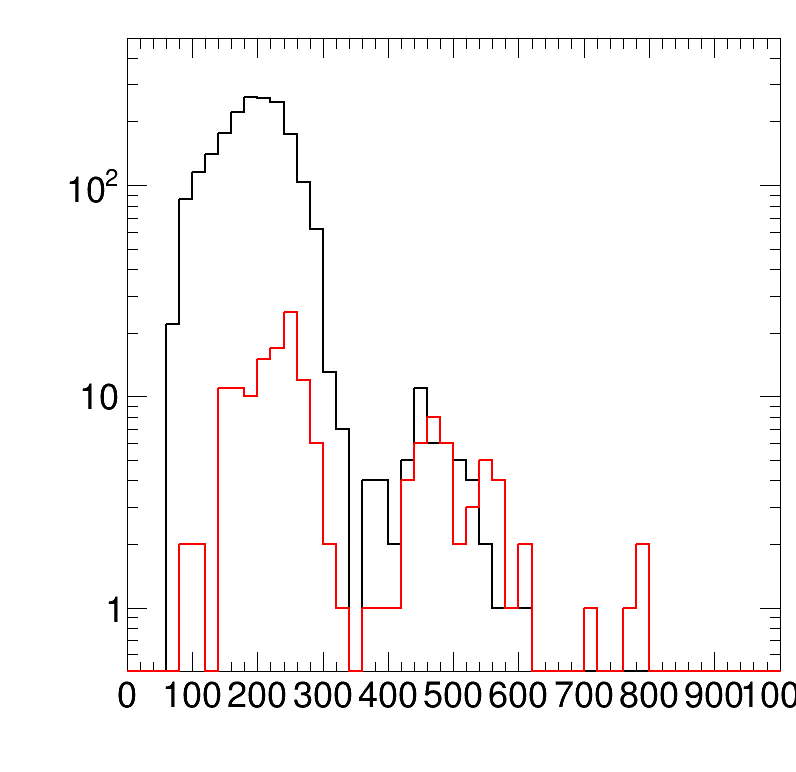

In [38]:
c = rt.TCanvas('','',800,800)
h = {}
m = '15'
for i, ct0 in enumerate([1000,10000]):
    print(ct0,i)
    k = f'{m}_{ct0}'

    T = tree[k]
    k = 'signal_' + k
    if np.count_nonzero(sel_ev[k])==0:continue

    ######################

    gLLP_ctau = np.sum(np.array(np.array(T['gLLP_ctau'].array()), dtype=np.float32), axis = 1)[sel_ev[k]][sel[k]]
    weight_ctau = weight_calc(gLLP_ctau, ctf/10., int(ct0)/10.) # convert everything to cm
    h[i] = create_TH1D(gLLP_ctau, str(i),str(i),binning = [50,0,1000])
    if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
    else:
        if i == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
        else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
    h[i].SetLineColor(std_color_list[i])
    h[i].Draw("hist same")
c.SetLogy()
c.Draw()

In [39]:
create_TH1D

<function histo_utilities.create_TH1D(x, name='h', title=None, binning=[26, 61.470596, 610.9368], weights=None, h2clone=None, axis_title=['', ''], bin_list=False)>